Проект команды **paranormal** в рамках домашнего задания Летней Школы **МТС.Тета**, направление "Машинное обучение"

#### Загрузка и настройка необходимых библиотек

In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
sns.set_theme(style='whitegrid', palette='deep')
warnings.filterwarnings('ignore')

## 1. Анализ данных

### 1.1. Предобработка датасета

In [3]:
# загрузка данных
data = pd.read_csv('data/diabetes.csv')
# убираем дубликаты
data = data.drop_duplicates()
# провидим в однообразное написание название переменных
data.columns = [c.replace(' ', '_').lower() for c in data.columns]
# заменяем значения 'Female', 'No' и 'Negative' на 0, 'Male', 'Yes' и 'Positive' - на 1
data = data.replace(["Yes", 'No', 'Male', 'Female', 'Positive', 'Negative'], [1, 0, 1, 0, 1, 0])
# сохраняем загруженные данные в отдельный датасет
df_diabetes = data.copy()
df_diabetes.head(5)

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


#### Переменные:
- polyuria - полиурия (увеличенное образование мочи)
- polydipsia - полидипсия (неутолимая жажда)
- sudden weight loss - внезапная потеря веса
- weakness - слабость
- polyphagia - полифагия (повышенный аппетит)
- genital thrush - генитальная молочница
- visual blurring - расплывчатость зрения
- itching - зуд
- irritability - раздражительность
- delayed healing - медленное заживление ран
- partial paresis - частичный парез (потеря мышечной силы)
- muscle stiffness - жесткость мышц
- alopecia - алопеция (выпадение волос)
- obesity - ожирение

### 2.2. Разведочный анализ данных

In [4]:
print('Уникальные значения переменных')
for col in df_diabetes.columns:
    print(col, df_diabetes[col].unique())

Уникальные значения переменных
age [40 58 41 45 60 55 57 66 67 70 44 38 35 61 54 43 62 39 48 32 42 52 53 37
 49 63 30 50 46 36 51 59 65 25 47 28 68 56 31 85 90 72 69 79 34 16 33 64
 27 29 26]
gender [1 0]
polyuria [0 1]
polydipsia [1 0]
sudden_weight_loss [0 1]
weakness [1 0]
polyphagia [0 1]
genital_thrush [0 1]
visual_blurring [0 1]
itching [1 0]
irritability [0 1]
delayed_healing [1 0]
partial_paresis [0 1]
muscle_stiffness [1 0]
alopecia [1 0]
obesity [1 0]
class [1 0]


In [5]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   age                 251 non-null    int64
 1   gender              251 non-null    int64
 2   polyuria            251 non-null    int64
 3   polydipsia          251 non-null    int64
 4   sudden_weight_loss  251 non-null    int64
 5   weakness            251 non-null    int64
 6   polyphagia          251 non-null    int64
 7   genital_thrush      251 non-null    int64
 8   visual_blurring     251 non-null    int64
 9   itching             251 non-null    int64
 10  irritability        251 non-null    int64
 11  delayed_healing     251 non-null    int64
 12  partial_paresis     251 non-null    int64
 13  muscle_stiffness    251 non-null    int64
 14  alopecia            251 non-null    int64
 15  obesity             251 non-null    int64
 16  class               251 non-null    int64
dt

<div class="alert alert-block alert-info"><b>
Пропущенных значений нет, нет необходимости в обработке пропусков
</div> 

In [6]:
df_diabetes.describe()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,48.864542,0.637450,0.525896,0.494024,0.414343,0.633466,0.466135,0.266932,0.442231,0.505976,0.282869,0.498008,0.446215,0.390438,0.358566,0.175299,0.689243
std,12.526036,0.481697,0.500327,0.500963,0.493592,0.482820,0.499849,0.443241,0.497644,0.500963,0.451293,0.500995,0.498092,0.488823,0.480538,0.380982,0.463728
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,58.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<div class="alert alert-block alert-info"><b>
    <p>В датасете данные пациентов в возрасте от 16 до 90 лет, медиана - 48 лет, средний 48.9 лет. </p>
    <p>Остальные переменные - бинарные. </p>
    <p>Датасет по целевому классу достаточно сбалансирован: 69% на 31%.
</div> 

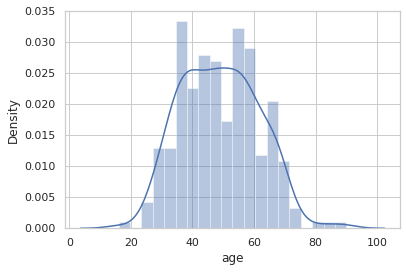

In [7]:
sns.distplot(df_diabetes['age'], bins=20);

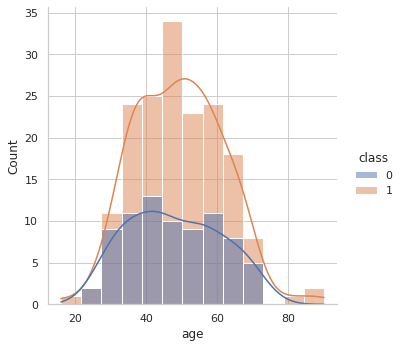

In [8]:
sns.displot(data=data, x='age', hue='class', kde = True);

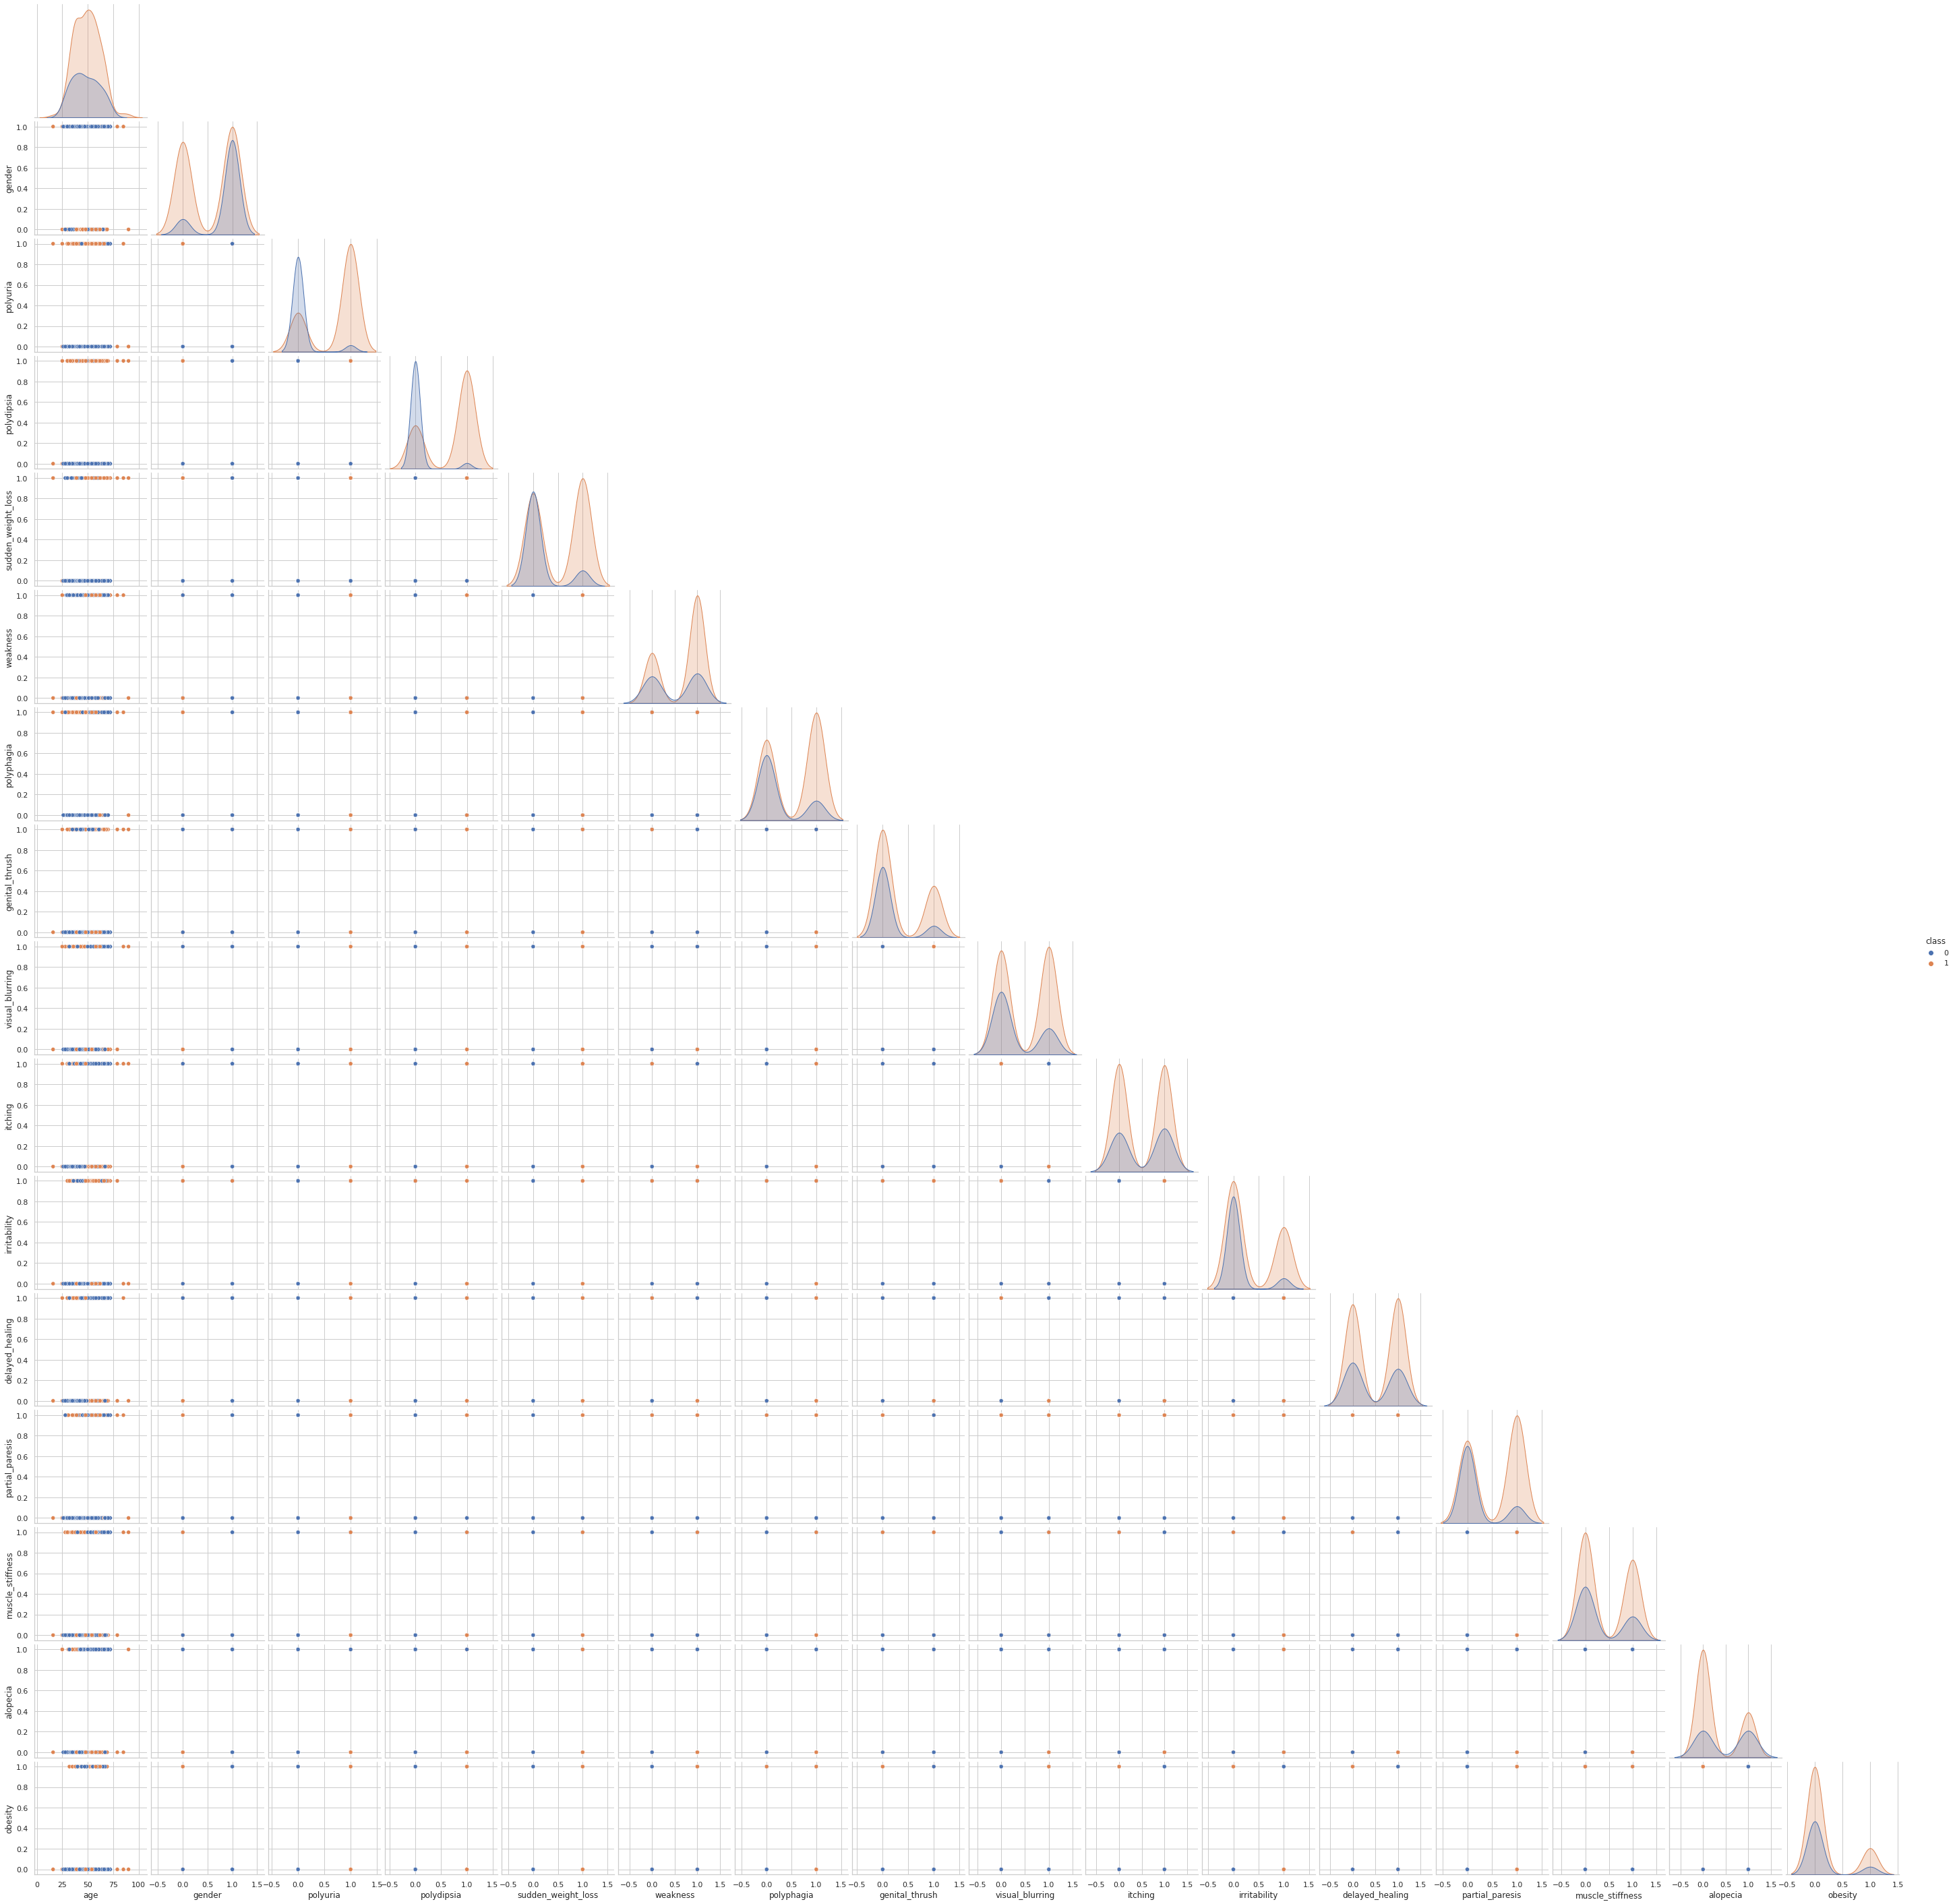

In [9]:
sns.pairplot(df_diabetes, hue='class', corner=True);

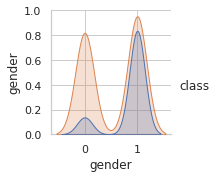

In [10]:
sns.pairplot(df_diabetes[['gender', 'class']], hue='class');

In [11]:
round(df_diabetes[df_diabetes['class'] == 1].groupby(['gender'])['weakness'].count() / df_diabetes[df_diabetes['class'] == 1]['weakness'].count() * 100, 2)

gender
0    46.24
1    53.76
Name: weakness, dtype: float64

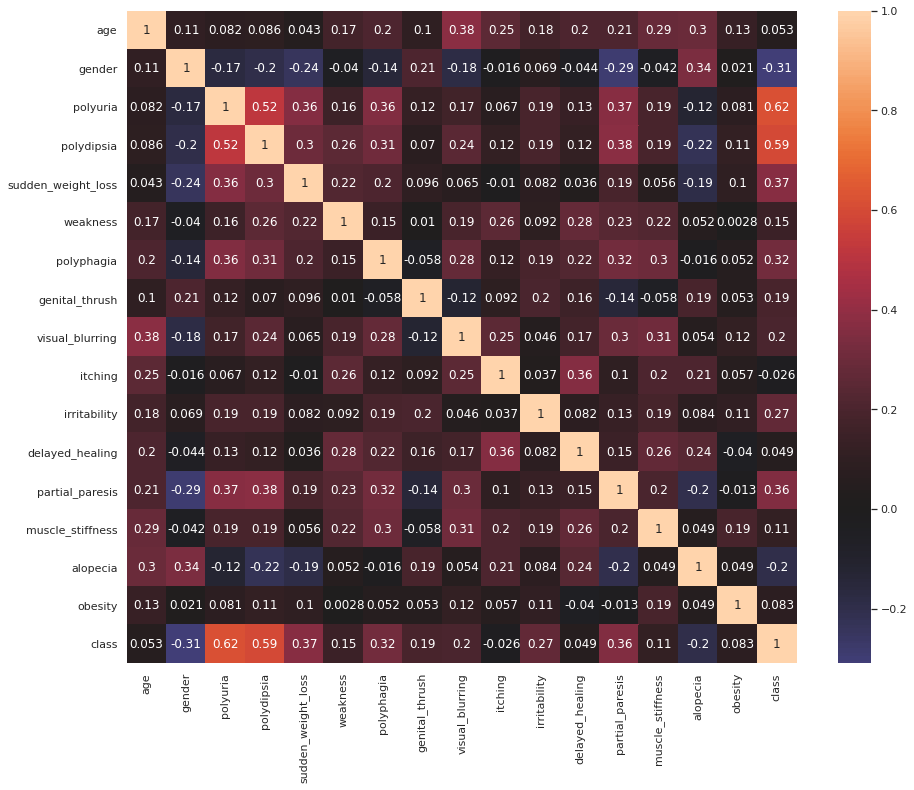

In [12]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(df_diabetes.corr(method='pearson'), center=0, square=False, annot=True, ax=ax);

In [13]:
pointbiserialr(df_diabetes.iloc[:, 1], df_diabetes.age)

PointbiserialrResult(correlation=0.10916809206933127, pvalue=0.0843335297777791)

<div class="alert alert-block alert-info"><b>
    Основные выводы
</div> 

<div class="alert alert-block alert-info"><b>
    
1) Диабет, особенно 2-го типа, наиболее распространен среди мужчин, чем среди женщин. https://www.news-medical.net/health/Diabetes-in-Men-versus-Women.aspx

2) Целевой класс сильно коррелирует с переменными полиурия и полидипсия.  https://www.jdrf.org/t1d-resources/about/symptoms/frequent-urination/

3) Также целевой класс коррелирует с внезапной потерей веса. https://www.medicinenet.com/is_weight_loss_caused_by_diabetes_dangerous/ask.htm

4) Перечисленные в исходных данных признаки (полиурия, полидипсия, внезапная потеря веса, слабость, повышенный аппетит, ожирание, зуд и т.п.) являются симптомами сахарного диабета.  Стоит отметить, что чем выше стадия сахарного диабета, тем заметнее проявление симптомов. 

5) Указан признак полиурия, но помимо этого возможно также ночное недержание. Можно добавить и такие признаки, как онемение и покалывание в руках и ногах, повышеная потливость, быстрая утомляемость, нехватка энергии, сильная усталость и сухость во рту из-за чувства жажды.

6) На представленных данных можно построить модель. В будущем в данные можно будет добавить указанные выше симптомы, а также расширить географию сбора данных.

7) Признаки не противоречат друг другу, данные соответствуют гипотезе.

</div> 

## 2. Моделирование

<div class="alert alert-block alert-info"><b>
    Решая поставленную задачу, мы испробовали несколько методов машинного обучения, включая логистическую регрессию, градиентный бустинг и случайный лес. Лучший результат на наших данных показал случайный лес по метрике F1. Приводим код только финальной модели.</div>

In [14]:
X, y = df_diabetes.drop('class', 1), df_diabetes['class']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [16]:
param_grid = {
    'n_estimators': np.arange(5, 51, 15),
    'max_depth': np.arange(5, 51, 15),
    'min_samples_split': np.arange(2, 11, 4),
    'min_samples_leaf': np.arange(1, 10, 4),
    'max_samples': np.arange(0.1, 0.99, 0.23), 
}

In [17]:
%%time
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
cv = GridSearchCV(rf, param_grid, cv=3).fit(X_train, y_train)

CPU times: user 1min 6s, sys: 4.5 s, total: 1min 11s
Wall time: 1min 19s


In [18]:
cv.best_params_

{'max_depth': 20,
 'max_samples': 0.56,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 35}

In [19]:
cv.best_estimator_

RandomForestClassifier(max_depth=20, max_samples=0.56, n_estimators=35,
                       n_jobs=-1, random_state=42)

In [20]:
y_pred = cv.best_estimator_.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

[Text(0, 0.5, 'healthy'), Text(0, 1.5, 'sick')]

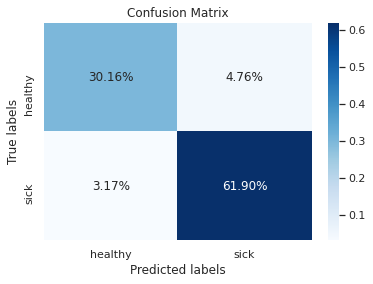

In [21]:
ax = plt.subplot()
sns.heatmap(conf_mat / np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.xaxis.set_ticklabels(['healthy', 'sick'])
ax.yaxis.set_ticklabels(['healthy', 'sick'])

In [22]:
def print_metrics(y_true, y_pred):
    print(f'f1_score: {f1_score(y_true, y_pred):.4f}')
    print(f'recall_score: {recall_score(y_true, y_pred):.4f}')
    print(f'precision_score: {precision_score(y_true, y_pred):.4f}')

In [23]:
print_metrics(y_test, y_pred)

f1_score: 0.9398
recall_score: 0.9512
precision_score: 0.9286


<div class="alert alert-block alert-info"><b>
    Полученное значение F1 меры соответствует ожидаемому качеству модели. </div> 

## 3. Сохраняем модель в бинарный файл

In [24]:
model_path = 'random_forest_diabet.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(cv.best_estimator_, file)

## 4. Загружаем модель и проверяем метрики

In [25]:
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)

In [26]:
loaded_model

RandomForestClassifier(max_depth=20, max_samples=0.56, n_estimators=35,
                       n_jobs=-1, random_state=42)

In [27]:
print_metrics(y_test, loaded_model.predict(X_test))

f1_score: 0.9398
recall_score: 0.9512
precision_score: 0.9286
